# Moon - Casadi

In [1]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from casadi import *
from pylab import plot, step, figure, legend, show, spy

opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.12


In [10]:
class Moon:
    def __init__ (self):
        self.opti = None
        self.params = None
        self.sol = None

N = 200 # number of control intervals

In [11]:
# lunar module
m_ascent_dry = 2445.0          # kg mass of ascent stage without fuel
m_ascent_fuel = 2376.0         # kg mass of ascent stage fuel
m_descent_dry = 2034.0         # kg mass of descent stage without fuel
m_descent_fuel = 8248.0        # kg mass of descent stage fuel

m_fuel = m_descent_fuel
m_dry = m_ascent_dry + m_ascent_fuel + m_descent_dry
m_total = m_dry + m_fuel

# descent engine characteristics
ve = 3050.0             # m/s
u_max = 45050.0/ve      # 45050 newtons / exhaust velocity

# landing mission specifications
h_initial = 100000.0           # meters
v_initial = -320               # orbital velocity m/s
g = 9.81/6                       # m/s**2

X0=np.array([h_initial/h_initial,v_initial/v_initial,m_total])

In [12]:
def deriv(x,u,t): 
    return vertcat(x[1]*v_initial/h_initial,               # dot h  
                   ve*u/v_initial - g/v_initial,   # dot v
                   -u*x[2],
                    u*x[2])              # dot fuel

def create_opti(Moon):
    opti = Opti() # Optimization problem
    # ---- decision variables ---------
    cX = opti.variable(4,N+1) # state trajectory
    cU = opti.variable(1,N)   # control trajectory (throttle)
    T = opti.variable()      # final time
    cx0 = cX[0,:] # h
    cx1 = cX[1,:] # v
    cx2 = cX[2,:] # m
    cx3 = cX[3,:] # m
    u = cU[0,:] # control

    # ---- objective          ---------
    opti.minimize(cx3[-1]) # race in minimal time

    # ---- dynamic constraints --------
    f = lambda x,u,t: deriv(x,u,t) # dx/dt = f(x,u)

    dt = T/N # length of a control interval
    for k in range(N-1): # loop over control intervals
        k1 = f(cX[:,k],         cU[:,k],k*dt)
        k2 = f(cX[:,k]+dt/2*k1, (cU[:,k]+cU[:,k+1])/2.0,(k+1/2)*dt)
        k3 = f(cX[:,k]+dt/2*k2, (cU[:,k]+cU[:,k+1])/2.0,(k+1/2)*dt)
        k4 = f(cX[:,k]+dt*k3,   cU[:,k+1],(k+1)*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps
    else:
        # now do the last step (no u(k+1))
        k = N-1
        k1 = f(cX[:,k],         cU[:,k],k*dt)
        k2 = f(cX[:,k]+dt/2*k1, cU[:,k],(k+1/2)*dt)
        k3 = f(cX[:,k]+dt/2*k2, cU[:,k],(k+1/2)*dt)
        k4 = f(cX[:,k]+dt*k3,   cU[:,k],(k+1)*dt)
        x_next = cX[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
        opti.subject_to(cX[:,k+1]==x_next) # close the gaps

    # ---- boundary conditions --------
    p = opti.parameter(1,3)

    # ---- boundary conditions --------
    opti.subject_to(cx0[0]==p[0]) # h0 ...
    opti.subject_to(cx1[0]==p[1]) # v0 
    opti.subject_to(cx2[0]==p[2]) # m0 ...
    opti.subject_to(cx3[0]==1) # J ...
    opti.subject_to(cx0[-1]==0)  # landed
    opti.subject_to(cx1[-1]==0)  # landed

    opti.subject_to(opti.bounded(0,u*cx2[:-1],u_max)) # control is limited

    opti.subject_to(T >= 100) # Time must be positive
    #opti.subject_to(cx2 >= m_dry) # mass above m dry
    opti.subject_to(cx0 >= 0) # pos height only
    opti.subject_to(cx1 >= 0) # neg velocity only
    
    opti.solver('ipopt',opts0) # set numerical backend

    Moon.params = p, T, cX, cU
    Moon.opti = opti
    
    return Moon

def min_casadi(X0,Moon):
    if Moon.opti is None:
        Moon = create_opti(Moon)

    p,T,cX,cU = Moon.params
    
    if Moon.sol is not None:
        Moon.opti.set_initial(Moon.sol.value_variables())

    for k in range(3):
        Moon.opti.set_value(p[k],X0[k])
    Moon.opti.set_initial(T,10)

    # ---- initial values for solver ---
    Moon.sol = Moon.opti.solve()   # actual solve
    return Moon 

In [13]:
Moon.opti = None
Moon.params = None
Moon.sol = None
Moon = min_casadi(X0,Moon)
print('Optimization was a success: '+str(Moon.sol.stats()['success']))

         but the previous value is set to disallow clobbering.
         The setting will remain as: "linear_solver ma27"
         but the previous value is set to disallow clobbering.
         The setting will remain as: "tol 0.001"
Optimization was a success: True


In [14]:
p,T,cX,cU = Moon.params

Tf = Moon.sol.value(T)
t = Tf*np.linspace(0, 1, N+1, endpoint=True)

h = Moon.sol.value(cX)[0,:]*h_initial
v = Moon.sol.value(cX)[1,:]*v_initial
m = Moon.sol.value(cX)[2,:]
u = Moon.sol.value(cU)[:]
u = u*m[:-1]

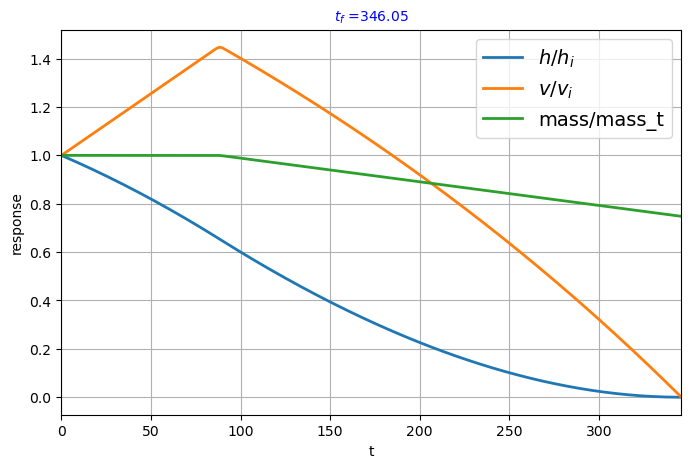

In [15]:
plt.figure(figsize = (8,5))
plt.plot(t,h/h_initial,label="$h/h_i$")
plt.plot(t,v/v_initial,label="$v/v_i$")
plt.plot(t,m/m_total,label=r"mass/mass_t")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.title('$t_f$ ='+str(round(Tf,3)))
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.savefig("figs/Moon_casadi_1.png")
plt.show()

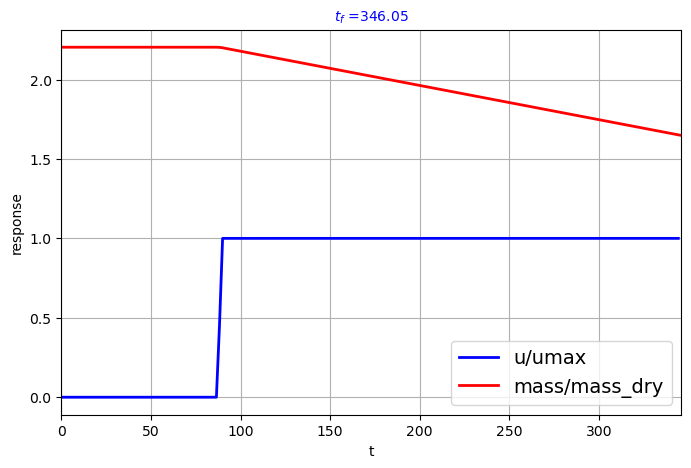

In [16]:
plt.figure(figsize = (8,5))
plt.plot(t[:-1],u/u_max,'b',label="u/umax")
plt.plot(t,m/m_dry,'r',label="mass/mass_dry")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.title('$t_f$ ='+str(round(Tf,3)))
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.savefig("figs/Moon_casadi_2.png")
plt.show()